In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact, FloatSlider, Dropdown

In [ ]:
# Function to extract conv layers from model
def get_conv_layers(model):
    conv_layers = []
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            conv_layers.append((name, module))
    return conv_layers

In [ ]:
# Function to plot histogram with interactive min/max
def plot_conv_weight_distribution(layer_name, weights, min_val, max_val):
    weights_flat = weights.flatten().detach().cpu().numpy()

    # Plot histogram
    plt.figure(figsize=(10, 5))
    plt.hist(weights_flat, bins=100, alpha=0.7, color='blue', label='Weights Distribution')

    # Plot vertical line for zero
    plt.axvline(0, color='red', linestyle='--', label='Zero')

    # Plot vertical lines for selected min and max
    plt.axvline(min_val, color='green', linestyle='-', label=f'Min: {min_val:.4f}')
    plt.axvline(max_val, color='orange', linestyle='-', label=f'Max: {max_val:.4f}')

    # Check where zero falls in range
    scale = (max_val - min_val) / (2**4 - 1)  # Example 4-bit quantization scale
    zero_pos = np.round((0 - min_val) / scale)  # Quantized zero position

    plt.title(f"Weight Distribution for Layer: {layer_name}\nQuantized Zero Position: {zero_pos}")
    plt.xlabel("Weight Value")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

# Interactive function to choose layer and set min/max
def interactive_layer_explorer(model):
    conv_layers = get_conv_layers(model)
    layer_names = [name for name, _ in conv_layers]

    # Function to update plot based on selection
    def update(layer_name, min_val, max_val):
        layer = dict(conv_layers)[layer_name]
        weights = layer.weight.data
        plot_conv_weight_distribution(layer_name, weights, min_val, max_val)

    # Dropdown to select layer
    layer_dropdown = Dropdown(options=layer_names, description='Conv Layer')

    # Sliders to adjust min and max dynamically
    def min_max_sliders(layer_name):
        layer = dict(conv_layers)[layer_name]
        weights = layer.weight.data.flatten().detach().cpu().numpy()
        min_w, max_w = weights.min(), weights.max()
        print(f"Layer '{layer_name}' - Weight min: {min_w:.4f}, max: {max_w:.4f}")

        min_slider = FloatSlider(value=min_w, min=min_w, max=max_w, step=(max_w - min_w) / 100, description='Min')
        max_slider = FloatSlider(value=max_w, min=min_w, max=max_w, step=(max_w - min_w) / 100, description='Max')

        #interact(update, layer_name=fixed(layer_name), min_val=min_slider, max_val=max_slider)
        interact(update, layer_name=(layer_name), min_val=min_slider, max_val=max_slider)

    interact(min_max_sliders, layer_name=layer_dropdown)

# Example usage with ResNet18
resnet = models.resnet18(pretrained=True)
interactive_layer_explorer(resnet)

interactive(children=(Dropdown(description='Conv Layer', options=('conv1', 'layer1.0.conv1', 'layer1.0.conv2',…

In [ ]:
from ipywidgets import interact, FloatSlider, Dropdown, IntSlider, fixed
# Function to plot histogram and quantization bins
def plot_conv_weight_distribution_with_quantization(layer_name, weights, min_val, max_val, num_bits=4):
    weights_flat = weights.flatten().detach().cpu().numpy()

    # Plot raw weight histogram
    plt.figure(figsize=(12, 6))
    plt.hist(weights_flat, bins=100, alpha=0.5, color='skyblue', label='Weight Distribution')

    # Plot zero line
    plt.axvline(0, color='red', linestyle='--', label='Zero Reference')

    # Plot min/max lines
    plt.axvline(min_val, color='green', linestyle='-', label=f'Min: {min_val:.4f}')
    plt.axvline(max_val, color='orange', linestyle='-', label=f'Max: {max_val:.4f}')

    # Calculate scale for quantization
    qmin, qmax = -(2 ** (num_bits - 1)), 2 ** (num_bits - 1) - 1  # e.g., -8 to 7 for 4-bit signed
    scale = (max_val - min_val) / (qmax - qmin)

    # Quantize weights
    quantized = np.round((weights_flat - min_val) / scale) + qmin
    quantized = np.clip(quantized, qmin, qmax).astype(np.int8)

    # Percentage of zeros after quantization
    zero_percentage = (np.sum(quantized == 0) / len(quantized)) * 100

    # Plot quantized bins histogram
    plt.hist(quantized, bins=np.arange(qmin - 0.5, qmax + 1.5, 1), alpha=0.7, color='purple', label='Quantized Bins')

    # Title and labels
    plt.title(f"Layer: {layer_name}\nZero % After Quantization: {zero_percentage:.2f}% (Quantized Zero Bin Shown)")
    plt.xlabel("Weight / Quantized Value")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

# Interactive explorer for layer and quantization params
def interactive_layer_explorer(model):
    conv_layers = get_conv_layers(model)
    layer_names = [name for name, _ in conv_layers]

    # Function to update plot based on selected layer and params
    def update(layer_name, min_val, max_val, num_bits):
        layer = dict(conv_layers)[layer_name]
        weights = layer.weight.data
        plot_conv_weight_distribution_with_quantization(layer_name, weights, min_val, max_val, num_bits)

    # Dropdown for layers
    layer_dropdown = Dropdown(options=layer_names, description='Conv Layer')

    # Function to create min/max sliders for selected layer
    def min_max_sliders(layer_name, num_bits):
        layer = dict(conv_layers)[layer_name]
        weights = layer.weight.data.flatten().detach().cpu().numpy()
        min_w, max_w = weights.min(), weights.max()
        print(f"Layer '{layer_name}' - Weight min: {min_w:.4f}, max: {max_w:.4f}")

        min_slider = FloatSlider(value=min_w, min=min_w, max=max_w, step=(max_w - min_w) / 100, description='Min')
        max_slider = FloatSlider(value=max_w, min=min_w, max=max_w, step=(max_w - min_w) / 100, description='Max')

        # Interactive connection
        interact(update, layer_name=fixed(layer_name), min_val=min_slider, max_val=max_slider, num_bits=fixed(num_bits))

    # Bit width slider (interactive)
    bit_slider = IntSlider(value=4, min=2, max=8, step=1, description='Bits')

    # Final interactive linkage
    interact(min_max_sliders, layer_name=layer_dropdown, num_bits=bit_slider)

# ✅ Example usage with pretrained ResNet18
resnet = models.resnet18(pretrained=True)
interactive_layer_explorer(resnet)

interactive(children=(Dropdown(description='Conv Layer', options=('conv1', 'layer1.0.conv1', 'layer1.0.conv2',…

In [ ]:
import numpy as np

def find_optimal_min_max(weights, num_bits=4, search_step=1):
    """
    Find optimal min and max for quantization that maximizes zeros after quantization.

    Args:
        weights (np.array): Flattened weight array.
        num_bits (int): Number of bits for quantization.
        search_step (int): Percentile search step size.

    Returns:
        (best_min, best_max, max_zeros)
    """
    qmin, qmax = -(2 ** (num_bits - 1)), 2 ** (num_bits - 1) - 1  # e.g., -8 to 7 for 4-bit signed

    best_min, best_max, max_zero_count = None, None, -1

    percentiles = np.arange(0, 50 + search_step, search_step)  # Search from (0-50) to (50-100)
    for lower_p in percentiles:
        for upper_p in percentiles:
            if lower_p + upper_p >= 100:  # invalid range
                continue

            min_val = np.percentile(weights, lower_p)
            max_val = np.percentile(weights, 100 - upper_p)

            if min_val >= max_val:
                continue  # invalid bounds

            # Quantization
            scale = (max_val - min_val) / (qmax - qmin)
            quantized = np.round((weights - min_val) / scale) + qmin
            quantized = np.clip(quantized, qmin, qmax).astype(np.int8)

            # Count zeros
            zero_count = np.sum(quantized == 0)

            # Update best
            if zero_count > max_zero_count:
                best_min, best_max, max_zero_count = min_val, max_val, zero_count

    zero_percentage = (max_zero_count / len(weights)) * 100
    return best_min, best_max, zero_percentage


In [ ]:
from ipywidgets import interact, FloatSlider, Dropdown, IntSlider, fixed
# Function to plot histogram and quantization bins
def plot_conv_weight_distribution_with_quantization(layer_name, weights, min_val, max_val, num_bits=4):
    weights_flat = weights.flatten().detach().cpu().numpy()

    # Plot raw weight histogram
    plt.figure(figsize=(12, 6))
    plt.hist(weights_flat, bins=100, alpha=0.5, color='skyblue', label='Weight Distribution')

    # Plot zero line
    plt.axvline(0, color='red', linestyle='--', label='Zero Reference')

    # Plot min/max lines
    plt.axvline(min_val, color='green', linestyle='-', label=f'Min: {min_val:.4f}')
    plt.axvline(max_val, color='orange', linestyle='-', label=f'Max: {max_val:.4f}')

    # Calculate scale for quantization
    qmin, qmax = -(2 ** (num_bits - 1)), 2 ** (num_bits - 1) - 1  # e.g., -8 to 7 for 4-bit signed
    scale = (max_val - min_val) / (qmax - qmin)

    # Quantize weights
    quantized = np.round((weights_flat - min_val) / scale) + qmin
    quantized = np.clip(quantized, qmin, qmax).astype(np.int8)

    # Percentage of zeros after quantization
    zero_percentage = (np.sum(quantized == 0) / len(quantized)) * 100

    # Plot quantized bins histogram
    plt.hist(quantized, bins=np.arange(qmin - 0.5, qmax + 1.5, 1), alpha=0.7, color='purple', label='Quantized Bins')

    # Title and labels
    plt.title(f"Layer: {layer_name}\nZero % After Quantization: {zero_percentage:.2f}% (Quantized Zero Bin Shown)")
    plt.xlabel("Weight / Quantized Value")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

# Interactive explorer for layer and quantization params
def interactive_layer_explorer(model):
    conv_layers = get_conv_layers(model)
    layer_names = [name for name, _ in conv_layers]

    # Function to update plot based on selected layer and params
    def update(layer_name, min_val, max_val, num_bits):
        layer = dict(conv_layers)[layer_name]
        weights = layer.weight.data
        plot_conv_weight_distribution_with_quantization(layer_name, weights, min_val, max_val, num_bits)

    # Dropdown for layers
    layer_dropdown = Dropdown(options=layer_names, description='Conv Layer')

    # Function to create min/max sliders for selected layer
    def min_max_sliders(layer_name, num_bits):
        layer = dict(conv_layers)[layer_name]
        weights = layer.weight.data.flatten().detach().cpu().numpy()
        #min_w, max_w = weights.min(), weights.max()
        min_w, max_w, _ = find_optimal_min_max(weights, num_bits)
        print(f"Layer '{layer_name}' - Weight min: {min_w:.4f}, max: {max_w:.4f}")

        min_slider = FloatSlider(value=min_w, min=min_w, max=max_w, step=(max_w - min_w) / 100, description='Min')
        max_slider = FloatSlider(value=max_w, min=min_w, max=max_w, step=(max_w - min_w) / 100, description='Max')

        # Interactive connection
        interact(update, layer_name=fixed(layer_name), min_val=min_slider, max_val=max_slider, num_bits=fixed(num_bits))

    # Bit width slider (interactive)
    bit_slider = IntSlider(value=4, min=2, max=8, step=1, description='Bits')

    # Final interactive linkage
    interact(min_max_sliders, layer_name=layer_dropdown, num_bits=bit_slider)

# ✅ Example usage with pretrained ResNet18
resnet = models.resnet18(pretrained=True)
interactive_layer_explorer(resnet)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


interactive(children=(Dropdown(description='Conv Layer', options=('conv1', 'layer1.0.conv1', 'layer1.0.conv2',…

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import numpy as np
import zstandard as zstd

# Function to extract Conv2D layers
def get_conv_layers(model):
    conv_layers = []
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            conv_layers.append((name, module))
    return conv_layers

# Quantize weights with given min/max and bit-width
def quantize_weights(weights, min_val, max_val, num_bits=4):
    qmin, qmax = -(2 ** (num_bits - 1)), 2 ** (num_bits - 1) - 1
    scale = (max_val - min_val) / (qmax - qmin)
    quantized = np.round((weights - min_val) / scale) + qmin
    quantized = np.clip(quantized, qmin, qmax).astype(np.int8)
    return quantized

# Greedy search for optimal min/max to maximize zeros
def find_optimal_min_max(weights, num_bits=4, search_step=5):
    qmin, qmax = -(2 ** (num_bits - 1)), 2 ** (num_bits - 1) - 1
    best_min, best_max, max_zero_count = None, None, -1
    percentiles = np.arange(0, 50 + search_step, search_step)
    for lower_p in percentiles:
        for upper_p in percentiles:
            if lower_p + upper_p >= 100:
                continue
            min_val = np.percentile(weights, lower_p)
            max_val = np.percentile(weights, 100 - upper_p)
            if min_val >= max_val:
                continue
            scale = (max_val - min_val) / (qmax - qmin)
            quantized = np.round((weights - min_val) / scale) + qmin
            quantized = np.clip(quantized, qmin, qmax).astype(np.int8)
            zero_count = np.sum(quantized == 0)
            if zero_count > max_zero_count:
                best_min, best_max, max_zero_count = min_val, max_val, zero_count
    return best_min, best_max

# Function to compress using zstd and calculate compression ratio
def compress_and_calculate_ratio(quantized_weights):
    compressor = zstd.ZstdCompressor(level=22)  # Highest compression level
    raw_bytes = quantized_weights.tobytes()
    compressed = compressor.compress(raw_bytes)
    raw_size = len(raw_bytes)
    compressed_size = len(compressed)
    compression_ratio = (1 - compressed_size / raw_size) * 100
    return compression_ratio, raw_size, compressed_size

# Main function to analyze and print per-layer compression
def analyze_resnet_compression(model, num_bits=4):
    conv_layers = get_conv_layers(model)
    compression_report = []

    for name, layer in conv_layers:
        weights = layer.weight.data.cpu().numpy().flatten()
        optimal_min, optimal_max = find_optimal_min_max(weights, num_bits=num_bits)
        quantized_weights = quantize_weights(weights, optimal_min, optimal_max, num_bits=num_bits)
        compression_ratio, raw_size, compressed_size = compress_and_calculate_ratio(quantized_weights)
        zero_percentage = (np.sum(quantized_weights == 0) / len(quantized_weights)) * 100

        compression_report.append({
            'Layer': name,
            'Zeros (%)': f"{zero_percentage:.2f}",
            'Raw Size (bytes)': raw_size,
            'Compressed Size (bytes)': compressed_size,
            'Compression Ratio (%)': f"{compression_ratio:.2f}"
        })

    return compression_report

# Display function to show in a nice table
def display_compression_report(report):
    from tabulate import tabulate
    print(tabulate(report, headers="keys", tablefmt="grid"))

# ✅ Example Usage:
resnet = models.resnet18(pretrained=True)
compression_report = analyze_resnet_compression(resnet, num_bits=4)
display_compression_report(compression_report)


+-----------------------+-------------+--------------------+---------------------------+-------------------------+
| Layer                 |   Zeros (%) |   Raw Size (bytes) |   Compressed Size (bytes) |   Compression Ratio (%) |
+=======================+=============+====================+===========================+=========================+
| conv1                 |       28.16 |               9408 |                      3709 |                   60.58 |
+-----------------------+-------------+--------------------+---------------------------+-------------------------+
| layer1.0.conv1        |       56.9  |              36864 |                      6987 |                   81.05 |
+-----------------------+-------------+--------------------+---------------------------+-------------------------+
| layer1.0.conv2        |       11.57 |              36864 |                     17793 |                   51.73 |
+-----------------------+-------------+--------------------+--------------------

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import numpy as np
import zstandard as zstd

# Function to extract Conv2D layers
def get_conv_layers(model):
    conv_layers = []
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            conv_layers.append((name, module))
    return conv_layers

# Quantize weights with given min/max and bit-width
def quantize_weights(weights, min_val, max_val, num_bits=4):
    qmin, qmax = -(2 ** (num_bits - 1)), 2 ** (num_bits - 1) - 1
    scale = (max_val - min_val) / (qmax - qmin)
    quantized = np.round((weights - min_val) / scale) + qmin
    quantized = np.clip(quantized, qmin, qmax).astype(np.int8)
    return quantized

# Greedy search for optimal min/max to maximize zeros
def find_optimal_min_max(weights, num_bits=4, search_step=5):
    qmin, qmax = -(2 ** (num_bits - 1)), 2 ** (num_bits - 1) - 1
    best_min, best_max, max_zero_count = None, None, -1
    percentiles = np.arange(0, 50 + search_step, search_step)
    for lower_p in percentiles:
        for upper_p in percentiles:
            if lower_p + upper_p >= 100:
                continue
            min_val = np.percentile(weights, lower_p)
            max_val = np.percentile(weights, 100 - upper_p)
            if min_val >= max_val:
                continue
            scale = (max_val - min_val) / (qmax - qmin)
            quantized = np.round((weights - min_val) / scale) + qmin
            quantized = np.clip(quantized, qmin, qmax).astype(np.int8)
            zero_count = np.sum(quantized == 0)
            if zero_count > max_zero_count:
                best_min, best_max, max_zero_count = min_val, max_val, zero_count
    return best_min, best_max

# Function to compress using zstd and calculate compression ratio
def compress_and_calculate_ratio(quantized_weights):
    compressor = zstd.ZstdCompressor(level=22)  # Highest compression level
    raw_bytes = quantized_weights.tobytes()
    compressed = compressor.compress(raw_bytes)
    raw_size = len(raw_bytes)
    compressed_size = len(compressed)
    compression_ratio = (1 - compressed_size / raw_size) * 100
    return compression_ratio, raw_size, compressed_size

# Main function to analyze and print per-layer compression
def analyze_resnet_compression(model, num_bits=4):
    conv_layers = get_conv_layers(model)
    compression_report = []

    for name, layer in conv_layers:
        weights = layer.weight.data.cpu().numpy().flatten()
        #optimal_min, optimal_max = find_optimal_min_max(weights, num_bits=num_bits)
        optimal_min, optimal_max = weights.min(), weights.max()
        quantized_weights = quantize_weights(weights, optimal_min, optimal_max, num_bits=num_bits)
        compression_ratio, raw_size, compressed_size = compress_and_calculate_ratio(quantized_weights)
        zero_percentage = (np.sum(quantized_weights == 0) / len(quantized_weights)) * 100

        compression_report.append({
            'Layer': name,
            'Zeros (%)': f"{zero_percentage:.2f}",
            'Raw Size (bytes)': raw_size,
            'Compressed Size (bytes)': compressed_size,
            'Compression Ratio (%)': f"{compression_ratio:.2f}"
        })

    return compression_report

# Display function to show in a nice table
def display_compression_report(report):
    from tabulate import tabulate
    print(tabulate(report, headers="keys", tablefmt="grid"))

# ✅ Example Usage:
resnet = models.resnet18(pretrained=True)
compression_report = analyze_resnet_compression(resnet, num_bits=4)
display_compression_report(compression_report)


+-----------------------+-------------+--------------------+---------------------------+-------------------------+
| Layer                 |   Zeros (%) |   Raw Size (bytes) |   Compressed Size (bytes) |   Compression Ratio (%) |
+=======================+=============+====================+===========================+=========================+
| conv1                 |        9.13 |               9408 |                      1930 |                   79.49 |
+-----------------------+-------------+--------------------+---------------------------+-------------------------+
| layer1.0.conv1        |       56.9  |              36864 |                      6987 |                   81.05 |
+-----------------------+-------------+--------------------+---------------------------+-------------------------+
| layer1.0.conv2        |        8.07 |              36864 |                      9099 |                   75.32 |
+-----------------------+-------------+--------------------+--------------------

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import zstandard as zstd
import torch.nn.utils.prune as prune
from sklearn.cluster import KMeans

# ---------- STEP 1: Structured Pruning (Optional) ----------
def apply_structured_pruning(model, amount=0.3):
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            prune.ln_structured(module, name='weight', amount=amount, n=2, dim=0)  # Prune entire channels
    return model

# ---------- STEP 2: Block-wise Quantization ----------
def blockwise_quantization(weights, num_bits=4, block_size=1, use_clustering=False, n_clusters=8):
    qmin, qmax = -(2 ** (num_bits - 1)), 2 ** (num_bits - 1) - 1
    flat_weights = weights.flatten()
    quantized_blocks = []
    block_count = int(np.ceil(len(flat_weights) / block_size))

    for i in range(block_count):
        block = flat_weights[i * block_size:(i + 1) * block_size]
        if len(block) == 0:
            continue
        if use_clustering:
            block = apply_weight_clustering(block, n_clusters=n_clusters)
        min_val, max_val = np.percentile(block, [1, 99])  # outlier-aware range
        if min_val == max_val:
            min_val -= 1e-5
            max_val += 1e-5
        scale = (max_val - min_val) / (qmax - qmin)
        quantized = np.round((block - min_val) / scale) + qmin
        quantized = np.clip(quantized, qmin, qmax).astype(np.int8)
        quantized_blocks.append(quantized)

    return np.concatenate(quantized_blocks).astype(np.int8)

# ---------- Optional: Weight Clustering ----------
def apply_weight_clustering(weights, n_clusters=8):
    weights = weights.reshape(-1, 1)
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(weights)
    clustered_weights = kmeans.cluster_centers_[kmeans.labels_].flatten()
    return clustered_weights

# ---------- STEP 3: Run-Length Encoding (RLE) ----------
def rle_encode(array):
    values, counts = [], []
    prev = array[0]
    count = 1
    for val in array[1:]:
        if val == prev:
            count += 1
        else:
            values.append(prev)
            counts.append(count)
            prev = val
            count = 1
    values.append(prev)
    counts.append(count)
    return np.array(values, dtype=np.int8), np.array(counts, dtype=np.int32)

# ---------- STEP 4: Zstd Compression ----------
def compress_with_zstd(data):
    compressor = zstd.ZstdCompressor(level=22)
    raw_bytes = data.tobytes()
    compressed = compressor.compress(raw_bytes)
    return compressed, len(raw_bytes), len(compressed)

# ---------- Full Pipeline for Each Conv Layer ----------
def full_pipeline(model, num_bits=4, prune_amount=0.3, block_size=64, use_clustering=False, n_clusters=8):
    model = apply_structured_pruning(model, amount=prune_amount)
    conv_layers = [(name, module) for name, module in model.named_modules() if isinstance(module, nn.Conv2d)]
    report = []

    for name, layer in conv_layers:
        weights = layer.weight.detach().cpu().numpy().flatten()
        quantized_weights = blockwise_quantization(weights, num_bits=num_bits, block_size=block_size,
                                                   use_clustering=use_clustering, n_clusters=n_clusters)

        # RLE Encoding
        rle_values, rle_counts = rle_encode(quantized_weights)
        rle_combined = np.concatenate([rle_values, rle_counts.view(np.int8)])  # Combine values and counts for compression

        # Compress using Zstd
        compressed, raw_size, compressed_size = compress_with_zstd(rle_combined)
        zero_percentage = (np.sum(quantized_weights == 0) / len(quantized_weights)) * 100
        compression_ratio = (1 - compressed_size / raw_size) * 100

        report.append({
            'Layer': name,
            'Zeros (%)': f"{zero_percentage:.2f}",
            'Raw Size (bytes)': raw_size,
            'Compressed Size (bytes)': compressed_size,
            'Compression Ratio (%)': f"{compression_ratio:.2f}"
        })

    return report

# ---------- Display Report ----------
def display_compression_report(report):
    from tabulate import tabulate
    print(tabulate(report, headers="keys", tablefmt="grid"))

# ---------- Example Usage ----------
if __name__ == "__main__":
    model = models.resnet18(pretrained=True)
    report = full_pipeline(
        model,
        num_bits=4,
        prune_amount=0.3,  # 30% structured pruning
        block_size=64,     # Block-wise quantization
        use_clustering=True,  # Enable clustering for better patterns
        n_clusters=8      # 8 clusters for weight sharing
    )
    display_compression_report(report)


Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/

+-----------------------+-------------+--------------------+---------------------------+-------------------------+
| Layer                 |   Zeros (%) |   Raw Size (bytes) |   Compressed Size (bytes) |   Compression Ratio (%) |
+=======================+=============+====================+===========================+=========================+
| conv1                 |       29.33 |              22435 |                      3499 |                   84.4  |
+-----------------------+-------------+--------------------+---------------------------+-------------------------+
| layer1.0.conv1        |       37.3  |              89740 |                     12526 |                   86.04 |
+-----------------------+-------------+--------------------+---------------------------+-------------------------+
| layer1.0.conv2        |       37.23 |             100815 |                     13640 |                   86.47 |
+-----------------------+-------------+--------------------+--------------------


Range: -0.1 to 0.1
Entropy: 1.9516 bits/symbol
Compression Ratio: 0.3312 (compressed/original)

Range: -0.5 to 0.5
Entropy: 4.6253 bits/symbol
Compression Ratio: 0.6396 (compressed/original)

Range: -1 to 1
Entropy: 6.6495 bits/symbol
Compression Ratio: 0.8397 (compressed/original)

Range: -3 to 3
Entropy: 7.4417 bits/symbol
Compression Ratio: 0.9339 (compressed/original)

Range: -5 to 5
Entropy: 6.7440 bits/symbol
Compression Ratio: 0.8506 (compressed/original)


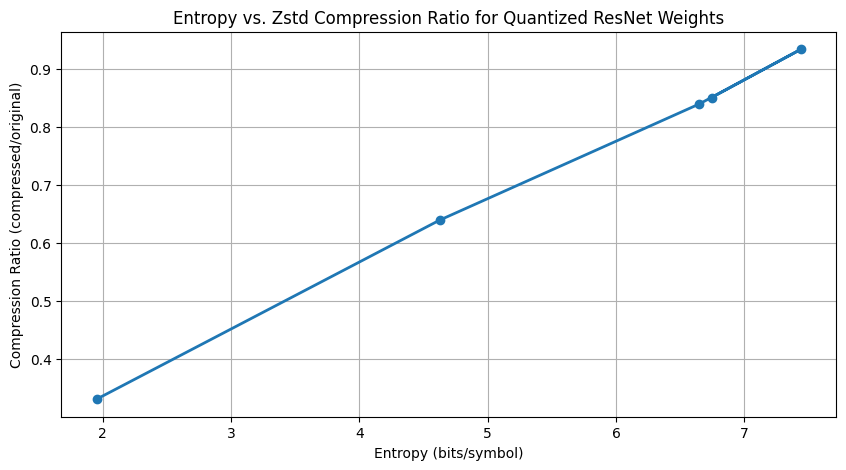

In [13]:
import numpy as np
import zstandard as zstd
import matplotlib.pyplot as plt
from collections import Counter

# Step 1: Simulate ResNet weights as normal distribution
def generate_resnet_weights(num_weights=1000000, mean=0, std=1, min_val=-1, max_val=1):
    weights = np.random.normal(mean, std, num_weights)
    # Clip weights to control min/max (this affects entropy!)
    weights = np.clip(weights, min_val, max_val)
    return weights

# Step 2: Quantize weights to 8-bit integers
def quantize_weights(weights, num_bits=8):
    min_w, max_w = weights.min(), weights.max()
    scale = (max_w - min_w) / (2 ** num_bits - 1)
    quantized = ((weights - min_w) / scale).round().astype(np.uint8)
    return quantized

# Step 3: Compute entropy H(X)
def compute_entropy(data):
    counter = Counter(data)
    total = len(data)
    probs = [count / total for count in counter.values()]
    entropy = -sum(p * np.log2(p) for p in probs if p > 0)
    return entropy

# Step 4: Compress quantized data using Zstd and get compression ratio
def compress_and_get_ratio(data):
    compressor = zstd.ZstdCompressor(level=3)  # medium compression level
    compressed = compressor.compress(data.tobytes())
    compression_ratio = len(compressed) / len(data.tobytes())
    return compression_ratio

# Step 5: Experiment across different min-max ranges
def experiment():
    min_max_ranges = [(-0.1, 0.1), (-0.5, 0.5), (-1, 1), (-3, 3), (-5, 5)]  # narrower to wider
    entropies = []
    compression_ratios = []

    for min_val, max_val in min_max_ranges:
        print(f"\nRange: {min_val} to {max_val}")
        weights = generate_resnet_weights(min_val=min_val, max_val=max_val)
        quantized = quantize_weights(weights)
        entropy = compute_entropy(quantized)
        ratio = compress_and_get_ratio(quantized)

        print(f"Entropy: {entropy:.4f} bits/symbol")
        print(f"Compression Ratio: {ratio:.4f} (compressed/original)")

        entropies.append(entropy)
        compression_ratios.append(ratio)

    # Plot results
    plt.figure(figsize=(10, 5))
    plt.plot(entropies, compression_ratios, 'o-', linewidth=2)
    plt.xlabel('Entropy (bits/symbol)')
    plt.ylabel('Compression Ratio (compressed/original)')
    plt.title('Entropy vs. Zstd Compression Ratio for Quantized ResNet Weights')
    plt.grid(True)
    plt.show()

experiment()


In [16]:
import torch
import torch.nn as nn
import torchvision.models as models
import numpy as np
import zstandard as zstd
from collections import Counter
from tabulate import tabulate

# Function to extract Conv2D layers
def get_conv_layers(model):
    conv_layers = []
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            conv_layers.append((name, module))
    return conv_layers

# Quantize weights with given min/max and bit-width
def quantize_weights(weights, min_val, max_val, num_bits=4):
    qmin, qmax = -(2 ** (num_bits - 1)), 2 ** (num_bits - 1) - 1
    scale = (max_val - min_val) / (qmax - qmin)
    quantized = np.round((weights - min_val) / scale) + qmin
    quantized = np.clip(quantized, qmin, qmax).astype(np.int8)
    return quantized

# Entropy computation function
def compute_entropy(data):
    counter = Counter(data)
    total = len(data)
    probs = [count / total for count in counter.values()]
    entropy = -sum(p * np.log2(p) for p in probs if p > 0)
    return entropy

# Greedy search for optimal min/max to maximize entropy (for better compression)
def find_optimal_min_max_to_maximize_entropy(weights, num_bits=4, search_step=5):
    qmin, qmax = -(2 ** (num_bits - 1)), 2 ** (num_bits - 1) - 1
    best_min, best_max, max_entropy = None, None, -np.inf
    percentiles = np.arange(0, 50 + search_step, search_step)
    for lower_p in percentiles:
        for upper_p in percentiles:
            if lower_p + upper_p >= 100:
                continue
            min_val = np.percentile(weights, lower_p)
            max_val = np.percentile(weights, 100 - upper_p)
            if min_val >= max_val:
                continue
            scale = (max_val - min_val) / (qmax - qmin)
            quantized = np.round((weights - min_val) / scale) + qmin
            quantized = np.clip(quantized, qmin, qmax).astype(np.int8)
            entropy = compute_entropy(quantized)
            if entropy > max_entropy:
                best_min, best_max, max_entropy = min_val, max_val, entropy
    return best_min, best_max, max_entropy

# Function to compress using zstd and calculate compression ratio
def compress_and_calculate_ratio(quantized_weights):
    compressor = zstd.ZstdCompressor(level=22)  # Highest compression level
    raw_bytes = quantized_weights.tobytes()
    compressed = compressor.compress(raw_bytes)
    raw_size = len(raw_bytes)
    compressed_size = len(compressed)
    compression_ratio = (1 - compressed_size / raw_size) * 100
    return compression_ratio, raw_size, compressed_size

# Main function to analyze and print per-layer compression
def analyze_resnet_compression(model, num_bits=4):
    conv_layers = get_conv_layers(model)
    compression_report = []

    for name, layer in conv_layers:
        weights = layer.weight.data.cpu().numpy().flatten()
        optimal_min, optimal_max, max_entropy = find_optimal_min_max_to_maximize_entropy(weights, num_bits=num_bits)
        quantized_weights = quantize_weights(weights, optimal_min, optimal_max, num_bits=num_bits)
        compression_ratio, raw_size, compressed_size = compress_and_calculate_ratio(quantized_weights)
        zero_percentage = (np.sum(quantized_weights == 0) / len(quantized_weights)) * 100

        print(f"Layer: {name}")
        print(f"Entropy (bits): {max_entropy:.2f}")
        print(f"Zeros (%): {zero_percentage:.2f}")
        print(f"Raw Size (bytes): {raw_size}")
        print(f"Compressed Size (bytes): {compressed_size}")
        print(f"Compression Ratio (%): {compression_ratio:.2f}")
        compression_report.append({
            'Layer': name,
            'Entropy (bits)': f"{max_entropy:.2f}",
            'Zeros (%)': f"{zero_percentage:.2f}",
            'Raw Size (bytes)': raw_size,
            'Compressed Size (bytes)': compressed_size,
            'Compression Ratio (%)': f"{compression_ratio:.2f}"
        })

    return compression_report

# Display function to show in a nice table
def display_compression_report(report):
    print(tabulate(report, headers="keys", tablefmt="grid"))

# ✅ Example Usage:
resnet = models.resnet18(pretrained=True)
compression_report = analyze_resnet_compression(resnet, num_bits=4)
display_compression_report(compression_report)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Layer: conv1
Entropy (bits): 3.59
Zeros (%): 22.17
Raw Size (bytes): 9408
Compressed Size (bytes): 3826
Compression Ratio (%): 59.33
Layer: layer1.0.conv1
Entropy (bits): 3.73
Zeros (%): 19.44
Raw Size (bytes): 36864
Compressed Size (bytes): 16295
Compression Ratio (%): 55.80
Layer: layer1.0.conv2
Entropy (bits): 3.88
Zeros (%): 8.27
Raw Size (bytes): 36864
Compressed Size (bytes): 18058
Compression Ratio (%): 51.01
Layer: layer1.1.conv1
Entropy (bits): 3.88
Zeros (%): 8.27
Raw Size (bytes): 36864
Compressed Size (bytes): 18138
Compression Ratio (%): 50.80
Layer: layer1.1.conv2
Entropy (bits): 3.89
Zeros (%): 8.05
Raw Size (bytes): 36864
Compressed Size (bytes): 18127
Compression Ratio (%): 50.83
Layer: layer2.0.conv1
Entropy (bits): 3.88
Zeros (%): 8.17
Raw Size (bytes): 73728
Compressed Size (bytes): 36180
Compression Ratio (%): 50.93
Layer: layer2.0.conv2
Entropy (bits): 3.90
Zeros (%): 7.58
Raw Size (bytes): 147456
Compressed Size (bytes): 72317
Compression Ratio (%): 50.96
Layer: 

In [17]:
import torch
import torch.nn as nn
import torchvision.models as models
import numpy as np
import zstandard as zstd
from collections import Counter
from tabulate import tabulate

# Function to extract Conv2D layers
def get_conv_layers(model):
    conv_layers = []
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            conv_layers.append((name, module))
    return conv_layers

# Quantize weights with given min/max and bit-width
def quantize_weights(weights, min_val, max_val, num_bits=4):
    qmin, qmax = -(2 ** (num_bits - 1)), 2 ** (num_bits - 1) - 1
    scale = (max_val - min_val) / (qmax - qmin)
    quantized = np.round((weights - min_val) / scale) + qmin
    quantized = np.clip(quantized, qmin, qmax).astype(np.int8)
    return quantized

# Entropy computation function
def compute_entropy(data):
    counter = Counter(data)
    total = len(data)
    probs = [count / total for count in counter.values()]
    entropy = -sum(p * np.log2(p) for p in probs if p > 0)
    return entropy

# Greedy search for optimal min/max to maximize entropy (for better compression)
def find_optimal_min_max_to_maximize_entropy(weights, num_bits=4, search_step=5):
    qmin, qmax = -(2 ** (num_bits - 1)), 2 ** (num_bits - 1) - 1
    best_min, best_max, max_entropy = weights.min(), weights.max(), -np.inf
    scale = (best_max - best_min) / (qmax - qmin)
    quantized = np.round((weights - best_min) / scale) + qmin
    quantized = np.clip(quantized, qmin, qmax).astype(np.int8)
    max_entropy = compute_entropy(quantized)
    # percentiles = np.arange(0, 50 + search_step, search_step)
    # for lower_p in percentiles:
    #     for upper_p in percentiles:
    #         if lower_p + upper_p >= 100:
    #             continue
    #         min_val = np.percentile(weights, lower_p)
    #         max_val = np.percentile(weights, 100 - upper_p)
    #         if min_val >= max_val:
    #             continue
    #         scale = (max_val - min_val) / (qmax - qmin)
    #         quantized = np.round((weights - min_val) / scale) + qmin
    #         quantized = np.clip(quantized, qmin, qmax).astype(np.int8)
    #         entropy = compute_entropy(quantized)
    #         if entropy > max_entropy:
    #             best_min, best_max, max_entropy = min_val, max_val, entropy
    return best_min, best_max, max_entropy

# Function to compress using zstd and calculate compression ratio
def compress_and_calculate_ratio(quantized_weights):
    compressor = zstd.ZstdCompressor(level=22)  # Highest compression level
    raw_bytes = quantized_weights.tobytes()
    compressed = compressor.compress(raw_bytes)
    raw_size = len(raw_bytes)
    compressed_size = len(compressed)
    compression_ratio = (1 - compressed_size / raw_size) * 100
    return compression_ratio, raw_size, compressed_size

# Main function to analyze and print per-layer compression
def analyze_resnet_compression(model, num_bits=4):
    conv_layers = get_conv_layers(model)
    compression_report = []

    for name, layer in conv_layers:
        weights = layer.weight.data.cpu().numpy().flatten()
        optimal_min, optimal_max, max_entropy = find_optimal_min_max_to_maximize_entropy(weights, num_bits=num_bits)
        quantized_weights = quantize_weights(weights, optimal_min, optimal_max, num_bits=num_bits)
        compression_ratio, raw_size, compressed_size = compress_and_calculate_ratio(quantized_weights)
        zero_percentage = (np.sum(quantized_weights == 0) / len(quantized_weights)) * 100

        print(f"Layer: {name}")
        print(f"Entropy (bits): {max_entropy:.2f}")
        print(f"Zeros (%): {zero_percentage:.2f}")
        print(f"Raw Size (bytes): {raw_size}")
        print(f"Compressed Size (bytes): {compressed_size}")
        print(f"Compression Ratio (%): {compression_ratio:.2f}")
        compression_report.append({
            'Layer': name,
            'Entropy (bits)': f"{max_entropy:.2f}",
            'Zeros (%)': f"{zero_percentage:.2f}",
            'Raw Size (bytes)': raw_size,
            'Compressed Size (bytes)': compressed_size,
            'Compression Ratio (%)': f"{compression_ratio:.2f}"
        })

    return compression_report

# Display function to show in a nice table
def display_compression_report(report):
    print(tabulate(report, headers="keys", tablefmt="grid"))

# ✅ Example Usage:
resnet = models.resnet18(pretrained=True)
compression_report = analyze_resnet_compression(resnet, num_bits=4)
display_compression_report(compression_report)


Layer: conv1
Entropy (bits): 1.83
Zeros (%): 9.13
Raw Size (bytes): 9408
Compressed Size (bytes): 1930
Compression Ratio (%): 79.49
Layer: layer1.0.conv1
Entropy (bits): 1.36
Zeros (%): 56.90
Raw Size (bytes): 36864
Compressed Size (bytes): 6987
Compression Ratio (%): 81.05
Layer: layer1.0.conv2
Entropy (bits): 1.87
Zeros (%): 8.07
Raw Size (bytes): 36864
Compressed Size (bytes): 9099
Compression Ratio (%): 75.32
Layer: layer1.1.conv1
Entropy (bits): 1.32
Zeros (%): 18.00
Raw Size (bytes): 36864
Compressed Size (bytes): 6755
Compression Ratio (%): 81.68
Layer: layer1.1.conv2
Entropy (bits): 1.98
Zeros (%): 44.33
Raw Size (bytes): 36864
Compressed Size (bytes): 9402
Compression Ratio (%): 74.50
Layer: layer2.0.conv1
Entropy (bits): 1.94
Zeros (%): 29.64
Raw Size (bytes): 73728
Compressed Size (bytes): 18287
Compression Ratio (%): 75.20
Layer: layer2.0.conv2
Entropy (bits): 1.52
Zeros (%): 6.04
Raw Size (bytes): 147456
Compressed Size (bytes): 30955
Compression Ratio (%): 79.01
Layer: la

In [19]:
import torch
import torch.nn as nn
import torchvision.models as models
import numpy as np
import zstandard as zstd
from collections import Counter
from tabulate import tabulate

# Function to extract Conv2D layers
def get_conv_layers(model):
    conv_layers = []
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            conv_layers.append((name, module))
    return conv_layers

# Quantize weights with given min/max and bit-width
def quantize_weights(weights, min_val, max_val, num_bits=4):
    qmin, qmax = -(2 ** (num_bits - 1)), 2 ** (num_bits - 1) - 1
    scale = (max_val - min_val) / (qmax - qmin)
    quantized = np.round((weights - min_val) / scale) + qmin
    quantized = np.clip(quantized, qmin, qmax).astype(np.int8)
    return quantized

# Entropy computation function
def compute_entropy(data):
    counter = Counter(data)
    total = len(data)
    probs = [count / total for count in counter.values()]
    entropy = -sum(p * np.log2(p) for p in probs if p > 0)
    return entropy

# Greedy search for optimal min/max to maximize entropy (for better compression)
def find_optimal_min_max_to_maximize_entropy(weights, num_bits=4, search_step=5):
    qmin, qmax = -(2 ** (num_bits - 1)), 2 ** (num_bits - 1) - 1
    best_min, best_max, max_entropy = None, None, -np.inf
    percentiles = np.arange(0, 50 + search_step, search_step)
    for lower_p in percentiles:
        for upper_p in percentiles:
            if lower_p + upper_p >= 100:
                continue
            min_val = np.percentile(weights, lower_p)
            max_val = np.percentile(weights, 100 - upper_p)
            if min_val >= max_val:
                continue
            scale = (max_val - min_val) / (qmax - qmin)
            quantized = np.round((weights - min_val) / scale) + qmin
            quantized = np.clip(quantized, qmin, qmax).astype(np.int8)
            entropy, _ , _ = compress_and_calculate_ratio(quantized)
            if entropy > max_entropy:
                best_min, best_max, max_entropy = min_val, max_val, entropy
    return best_min, best_max, max_entropy

# Function to compress using zstd and calculate compression ratio
def compress_and_calculate_ratio(quantized_weights):
    compressor = zstd.ZstdCompressor(level=22)  # Highest compression level
    raw_bytes = quantized_weights.tobytes()
    compressed = compressor.compress(raw_bytes)
    raw_size = len(raw_bytes)
    compressed_size = len(compressed)
    compression_ratio = (1 - compressed_size / raw_size) * 100
    return compression_ratio, raw_size, compressed_size

# Main function to analyze and print per-layer compression
def analyze_resnet_compression(model, num_bits=4):
    conv_layers = get_conv_layers(model)
    compression_report = []

    for name, layer in conv_layers:
        weights = layer.weight.data.cpu().numpy().flatten()
        optimal_min, optimal_max, max_entropy = find_optimal_min_max_to_maximize_entropy(weights, num_bits=num_bits)
        quantized_weights = quantize_weights(weights, optimal_min, optimal_max, num_bits=num_bits)
        compression_ratio, raw_size, compressed_size = compress_and_calculate_ratio(quantized_weights)
        zero_percentage = (np.sum(quantized_weights == 0) / len(quantized_weights)) * 100

        print(f"Layer: {name}")
        print(f"Entropy (bits): {max_entropy:.2f}")
        print(f"Zeros (%): {zero_percentage:.2f}")
        print(f"Raw Size (bytes): {raw_size}")
        print(f"Compressed Size (bytes): {compressed_size}")
        print(f"Compression Ratio (%): {compression_ratio:.2f}")
        compression_report.append({
            'Layer': name,
            'Entropy (bits)': f"{max_entropy:.2f}",
            'Zeros (%)': f"{zero_percentage:.2f}",
            'Raw Size (bytes)': raw_size,
            'Compressed Size (bytes)': compressed_size,
            'Compression Ratio (%)': f"{compression_ratio:.2f}"
        })

    return compression_report

# Display function to show in a nice table
def display_compression_report(report):
    print(tabulate(report, headers="keys", tablefmt="grid"))

# ✅ Example Usage:
resnet = models.resnet18(pretrained=True)
compression_report = analyze_resnet_compression(resnet, num_bits=4)
display_compression_report(compression_report)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Layer: conv1
Entropy (bits): 86.93
Zeros (%): 0.09
Raw Size (bytes): 9408
Compressed Size (bytes): 1230
Compression Ratio (%): 86.93
Layer: layer1.0.conv1
Entropy (bits): 85.94
Zeros (%): 0.07
Raw Size (bytes): 36864
Compressed Size (bytes): 5182
Compression Ratio (%): 85.94
Layer: layer1.0.conv2
Entropy (bits): 81.25
Zeros (%): 0.08
Raw Size (bytes): 36864
Compressed Size (bytes): 6911
Compression Ratio (%): 81.25
Layer: layer1.1.conv1
Entropy (bits): 83.39
Zeros (%): 0.02
Raw Size (bytes): 36864
Compressed Size (bytes): 6123
Compression Ratio (%): 83.39
Layer: layer1.1.conv2
Entropy (bits): 79.28
Zeros (%): 0.17
Raw Size (bytes): 36864
Compressed Size (bytes): 7638
Compression Ratio (%): 79.28
Layer: layer2.0.conv1
Entropy (bits): 79.16
Zeros (%): 0.36
Raw Size (bytes): 73728
Compressed Size (bytes): 15368
Compression Ratio (%): 79.16
Layer: layer2.0.conv2
Entropy (bits): 83.00
Zeros (%): 0.02
Raw Size (bytes): 147456
Compressed Size (bytes): 25063
Compression Ratio (%): 83.00
Layer: